# Basic characterizations of LA Q1
### using Experiment and Analysis classes

In [47]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm import generate_qua_script
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import scipy.io as sio

from ExperimentClass import ExperimentHandle

from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 4 # for LA Q1
res_index = 4 # for LA Q1
flux_index = 4 # for LA Q1
TLS_index = 0 # for TLS of interest

In [401]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [5]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [4]:
# set DC offset of last measured qubit to zero
qubit_index = 3 # for LA Q1
res_index = 3 # for LA Q1
flux_index = 3 # for LA Q1
machine.flux_lines[flux_index].dc_voltage = 0
machine = Analysis.set_machine(machine)

In [9]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2023-11-13 11:25:46,439 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-13 11:25:46,461 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [6]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-03-12 08:45:22,348 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-03-12 08:45:22,351 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 08:45:22,370 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.277 GHz, -50.000 MHz)
2024-03-12 08:45:30,919 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (5.758 GHz, -50.000 MHz)
2024-03-12 08:45:44,246 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## resonator switch calibration

### switch delay

In [ ]:
# reduce the resonator freq, so sig is stronger
machine.resonators[res_index].f_readout -= 2E6
machine._save("quam_state.json")

In [ ]:
%matplotlib inline
rr_switch_delay_sweep = np.arange(70,110,1)
machine, rr_switch_delay_sweep, sig_amp = Experiment.exp1D.RR.rr_switch_delay(rr_switch_delay_sweep, qubit_index, res_index, flux_index, 
                          n_avg = 160E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

### switch buffer

In [ ]:
%matplotlib inline
rr_switch_buffer_sweep = np.arange(0,25 + 1,1)
machine, rr_switch_delay_sweep, sig_amp = Experiment.exp1D.RR.rr_switch_buffer(rr_switch_buffer_sweep, qubit_index, res_index, flux_index, 
                          n_avg = 20E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

## Time of flight

DC offset to add to I: -0.000018 V
DC offset to add to Q: 0.000137 V
TOF to add: 0.0 ns


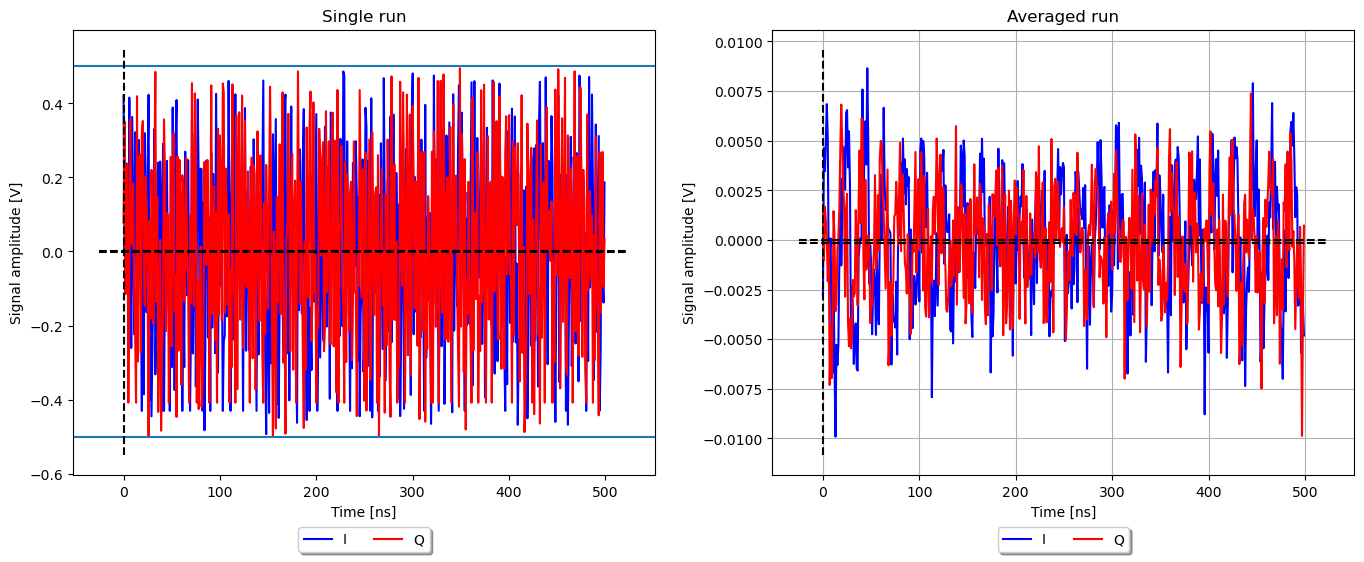

In [33]:
# time_of_flight experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 20E3, cd_time = 20E3, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)

# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [9]:
# machine.global_parameters.time_of_flight -= 20
# machine = Analysis.set_machine(machine)

In [34]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [37]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-5E6,5E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 5E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.65s


resonator frequency: 6226.367 MHz
Execution stopped by user!


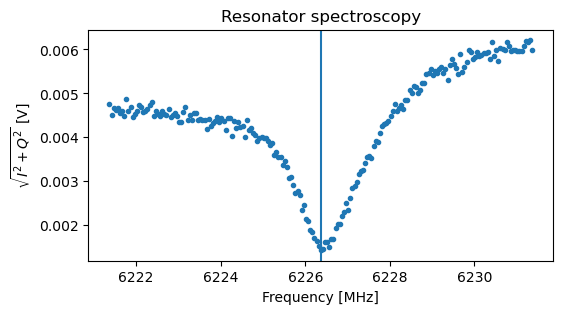

In [38]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

## 2D RO resonator spectroscopy vs DC flux

In [39]:
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-17e6, 7e6, 0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, 
                                plot_flag = False, n_avg = 5E3, cd_time = 10E3)

Progress: [##################################################] 100.0% (n=37/37)


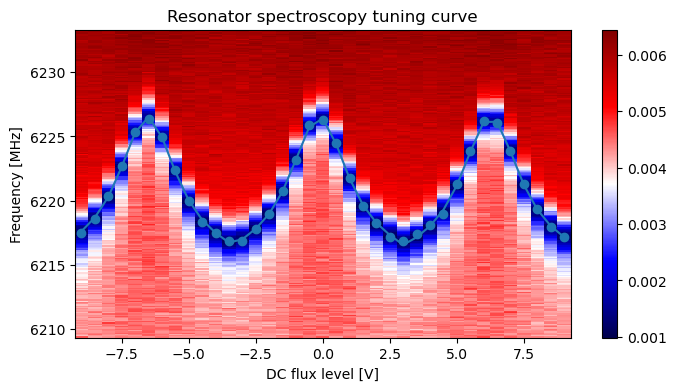

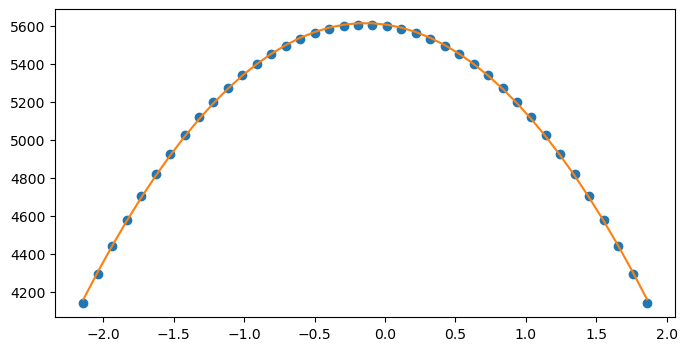

In [43]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = [6227, 160, 30E3, 0.05, 0.4, 100])
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [50]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [52]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [407]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 51.86s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 51.91s
resonator frequency: 6226.463 MHz


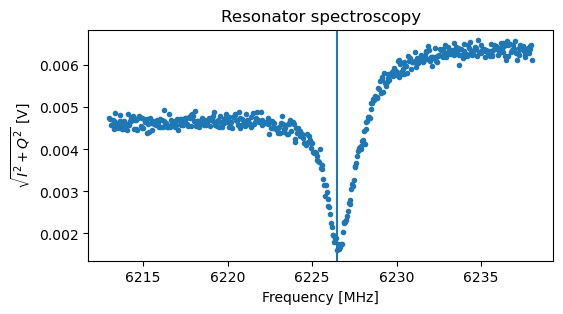

In [225]:
# calibrate RO
%matplotlib qt
# res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([flux_index,machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 20E6 + 1, 0.05E6)

machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 20E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

In [423]:
# qubit_freq_sweep = np.arange(5.7E9,5.8E9+1,0.05E6)
# for the DC flux
qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
# # for the fast flux
# qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
machine.qubits[qubit_index].lo = int(qubit_freq_est.tolist()) + 50E6
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-100E6, 100E6 + 1, 1E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1, ff_amp = 0.0, n_avg = 5E3, cd_time = 20E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 21.12s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 21.16s


In [425]:
%matplotlib qt
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
# # qubit_freq = 5730.4E6
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

resonant frequency: 5682.863 MHz


In [426]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2024-03-12 13:18:36,887 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 13:18:36,901 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.276 GHz, -50.000 MHz)
2024-03-12 13:18:44,250 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (5.733 GHz, -50.000 MHz)
2024-03-12 13:18:57,598 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [427]:
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01 + 0E6
machine = Analysis.set_machine(machine)

## Rabi

### time rabi

In [421]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 45 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1, n_avg = 10E3, cd_time = 15E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 6.62s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 6.67s


rabi_pi_pulse: 97.1 ns
half period: 90.82 ns


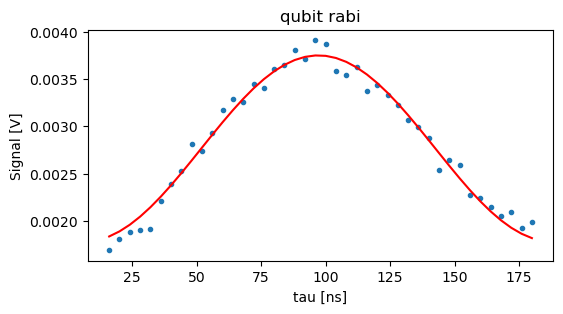

In [422]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [394]:
machine.qubits[qubit_index].pi_length[0] = 100
machine = Analysis.set_machine(machine)

### power rabi

In [337]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.01, 1.5, 0.04) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 20E3, cd_time = 40E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 30.93s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 30.97s


rabi_pi_pulse_amp: 0.18132 V
half period: 0.1657959 V


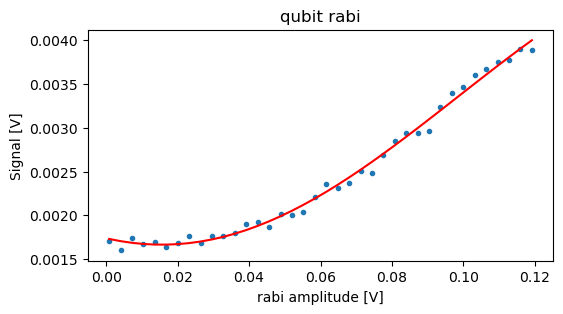

In [338]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [420]:
machine.qubits[qubit_index].pi_amp[0] = 0.0285
machine = Analysis.set_machine(machine)

In [254]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.tolist() 
machine = Analysis.set_machine(machine)

## calibrate qubit XY line switch

### switch delay

In [ ]:
%matplotlib inline
qubit_switch_delay_sweep = np.arange(70,110,1)
for i in range(4):
    machine, qubit_switch_delay_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_switch_delay(qubit_switch_delay_sweep, qubit_index, res_index, flux_index, 
                              n_avg = 160E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = False)

### switch buffer

In [ ]:
%matplotlib inline
qubit_switch_buffer_sweep = np.arange(0,70 + 1,2)
for k in range(5):
    machine, qubit_switch_buffer_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_switch_buffer(qubit_switch_buffer_sweep, qubit_index, res_index, flux_index, 
                              n_avg = 20E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

## T1

In [187]:
%matplotlib qt
tau_sweep_abs = np.arange(100,20E3+1,400)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 80E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 22.58s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 22.62s


Qubit T1 [us]: 4.151577467170727


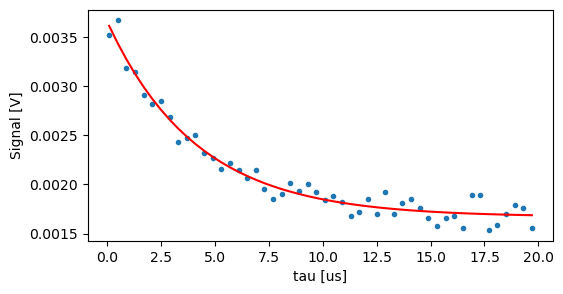

In [188]:
%matplotlib inline
q5_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q5_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey with virtual rotation

In [367]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 100 + 0.1, 1)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          n_avg = 1E5, detuning = 5E6, cd_time = 10E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Execution stopped by user!#################                  ] 65.2% (n=65232/100000.0) --> elapsed time: 68.59s


Qubit T2* [ns]: 195.11458907880845
Detuning [MHz]: 25.271761991471536
Exponent n: 2.172093800539857


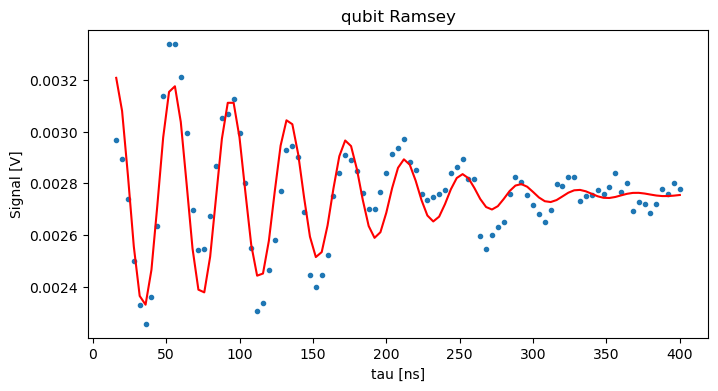

In [368]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

In [ ]:
%matplotlib qt
# FFT
x = ramsey_duration_sweep
y = sig_amp
freq =  np.fft.fftfreq(len(x), abs(x[0] - x[1]) / u.s)
w = np.fft.fft(y)
new_w = w[1 : len(freq // 2)]
new_f = freq[1 : len(freq // 2)]
ind = new_f > 0
new_f = new_f[ind]
new_w = new_w[ind]
yy = np.abs(new_w)
first_read_data_ind = np.where(yy[1:] - yy[:-1] > 0)[0][0]  # away from the DC peak
new_f = new_f[first_read_data_ind:]
new_w = new_w[first_read_data_ind:]

plt.plot((new_f/1e6), np.abs(new_w))
plt.xlabel("Frequency [MHz]")
plt.ylabel("FFT [a.u.]")



In [ ]:
## Power spectrum
delta = abs(x[0] - x[1]) / u.s
Fs = 1 / delta  # Sampling frequency
L = np.size(x)
NFFT = int(2 * 2 ** np.ceil(np.log2(L)))
Freq = Fs / 2 * np.linspace(0, 1, NFFT // 2 , endpoint=True)
Y = np.fft.fft(y - np.mean(y), NFFT) / L
DataY = abs(Y[0:(NFFT // 2)]) ** 2
plt.plot(Freq/1e6, DataY)
plt.xlabel("Frequency [MHz]")
plt.ylabel("FFT [a.u.]")


## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-180E6, -100E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 80
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 3.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## residual |e> state population

### |e> readout calibration

In [ ]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([flux_index,machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 10E3, cd_time = 20E3, plot_flag = False, readout_state = 'e', simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [256]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2023-11-14 15:06:31,611 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-14 15:06:31,617 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.276 GHz, -50.000 MHz)
2023-11-14 15:06:38,136 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (5.779 GHz, -50.000 MHz)
2023-11-14 15:06:49,699 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### A_ref

In [ ]:
%matplotlib qt
#rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = np.array([80/4, 160/4])  
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 1E7, cd_time = 20E3, readout_state = 'e', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

### A_sig

In [ ]:
%matplotlib qt
#rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = np.array([80/4, 160/4])  
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep_thermal, sig_amp_thermal = Experiment.exp1D.Rabi.ef_rabi_length_thermal(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 0.0,  n_avg = 1E7, cd_time = 20E3, readout_state = 'e', plot_flag = False, machine = machine, 
          simulate_flag = False, simulation_len = 10_000)

## 2D qubit spectroscopy vs dc flux

In [380]:
machine = Analysis.get_machine()

In [381]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.4,0.4+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                                                                             n_avg = 5E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

Progress: [##################################################] 100.0% (n=41/41) --> elapsed time: 1676.08s
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [382]:
# udpate the sweet spot
%matplotlib qt
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = True)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -0.12597 V


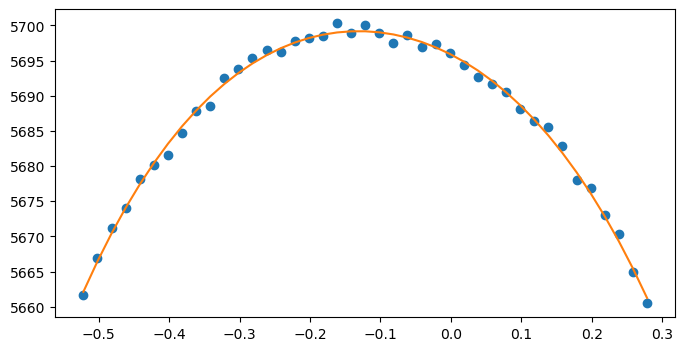

In [384]:
# save the sweep spot flux according to fitted parameter
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)



## 2D qubit spectroscopy vs fast flux

In [385]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, to find the initial fast flux tuning curve

In [390]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2024-03-12 13:04:02,622 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 13:04:02,633 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [428]:
# try the experiment
%matplotlib qt
ff_sweep = np.arange(0,0.3+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
if False: # first time running this, no AC_tuning_curve
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 4.1, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)
else: # after the first run 
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

2024-03-12 13:19:20,328 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 13:19:20,340 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (5.414 GHz, 290.000 MHz)
2024-03-12 13:19:25,833 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-03-12 13:20:07,716 - qm - INFO     - Performing health check.4% (n=5/7) --> elapsed time: 47.38s


INFO:qm.api.frontend_api:Performing health check


2024-03-12 13:20:07,728 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (5.194 GHz, 290.000 MHz)
2024-03-12 13:20:13,219 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=7/7) --> elapsed time: 81.95s
2024-03-12 13:20:42,280 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 13:20:42,291 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (4.881 GHz, 290.000 MHz)
2024-03-12 13:20:47,967 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [ ]:
# plots tuning curve with fast flux from loaded data 

import scipy.io as sio
tPath = os.path.join(r'Z:\LabberData_DF5\QM_Data_DF5','2023','11','Data_1116')
filename = 'Q5-qubit_freq_vs_fast_flux-1116-1306'
file = os.path.join(tPath, filename)
file_open = sio.loadmat(file)
%matplotlib qt
qubit_freq_sweep =file_open['Q_freq']
ff_sweep_abs = file_open['fast_flux_sweep']
sig_amp_qubit = file_open['sig_amp_qubit']

qubit_freq_sweep = qubit_freq_sweep.reshape(np.size(ff_sweep_abs),
                                                np.size(qubit_freq_sweep) // np.size(ff_sweep_abs))
sig_amp_qubit = sig_amp_qubit.reshape(np.size(ff_sweep_abs),
                                          np.size(sig_amp_qubit) // np.size(ff_sweep_abs))

sort_index = np.argsort(ff_sweep_abs[0])
qubit_freq_sweep = qubit_freq_sweep[sort_index,:]
sig_amp_qubit = sig_amp_qubit[sort_index,:]
ff_sweep_abs = ff_sweep_abs[0][sort_index]
_, ff_sweep_plt = np.meshgrid(qubit_freq_sweep[0, :], ff_sweep_abs)


plt.pcolormesh(ff_sweep_plt, qubit_freq_sweep / u.MHz, sig_amp_qubit, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)



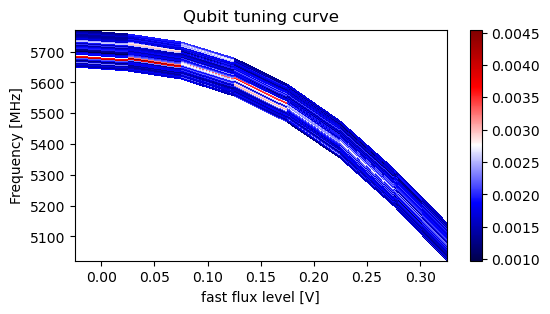

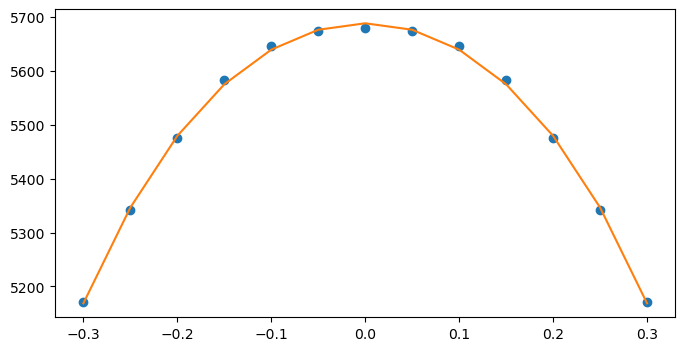

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [429]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [438]:
machine = Analysis.get_machine()

In [439]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.5E9, -5E6)
#qubit_freq_sweep = np.arange(q_freq_max,4E9,-100E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 20E3, plot_flag = True)

2024-03-12 13:39:49,775 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 13:39:49,791 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (5.390 GHz, 200.000 MHz)
2024-03-12 13:39:55,006 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1015.97s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1016.13s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1016.07s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1016.23s
2024-03-12 14:14:12,255 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 14:14:12,269 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (5.190 GHz, 200.000 MHz)
2024-03-12 14:14:17,684 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1015.92s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1016.07s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1016.12s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1016.28s
2024-03-12 14:48:36,809 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 14:48:36,820 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (4.590 GHz, 200.000 MHz)
2024-03-12 14:48:42,560 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1016.11s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1016.26s
2024-03-12 15:06:00,602 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 15:06:00,614 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (4.390 GHz, 200.000 MHz)
2024-03-12 15:06:06,101 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 965.20s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 965.36s
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [435]:
# save the fitted tuning curve
%matplotlib qt
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

In [437]:
%matplotlib qt
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.pcolormesh(qubit_freq_sweep / u.MHz, ff_sweep_abs, sig_amp_qubit, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# TLS experiments

## TLS SWAP spectroscopy

In [5]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

2023-11-22 09:31:05,862 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-22 09:31:05,876 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.276 GHz, -50.000 MHz)
2023-11-22 09:31:12,212 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (5.779 GHz, -50.000 MHz)
2023-11-22 09:31:24,529 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### coarse, no baking

In [153]:
%matplotlib qt
tau_sweep_abs = np.arange(16,200,4)
ff_sweep_abs = np.arange(0.30,0.38,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 4E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 313.78s
Execution stopped by user!


### fine, with baking

In [319]:
%matplotlib qt
tau_sweep_abs = np.arange(4,300,1)
ff_sweep_abs = np.arange(0.325,0.355,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1876.86s


In [333]:
plt.pcolormesh(ff_sweep_abs, tau_sweep_abs, sig_amp, cmap="seismic", shading='nearest')

In [324]:
# FFT (note that the commented lins are sinple FFT, while what is actually being shown is the power spectrum)

%matplotlib qt
# w_tot = []
x_f = ff_sweep_abs
x_t = tau_sweep_abs
y = sig_amp
DataY_f = []
delta = abs(x_t[0] - x_t[1]) / u.s
Fs = 1 / delta  # Sampling frequency
L = np.size(x_t)
NFFT = int(2 * 2 ** np.ceil(np.log2(L)))
Freq = Fs / 2 * np.linspace(0, 1, NFFT // 2 , endpoint=True)
# freq =  np.fft.fftfreq(len(x_t), abs(x_t[0] - x_t[1]) / u.s)

for i, v in enumerate(x_f):
#     w = np.fft.fft([k[i] for k in y])
#     new_w = w[1 : len(freq // 2)]
#     new_f = freq[1 : len(freq // 2)]
#     ind = new_f > 0
#     new_f = new_f[ind]
#     new_w = new_w[ind]
#     yy = np.abs(new_w)
#     sz_x = np.shape(new_f)
#     sz_w = np.shape(new_w)
#     w_tot.append(new_w) 
    Y_pow = np.fft.fft([k[i] for k in y] - np.mean([k[i] for k in y]), NFFT) / L
    DataY = abs(Y_pow[0:(NFFT // 2)]) ** 2
    DataY_f.append(DataY) 

# w_tot = np.concatenate(w_tot, axis = 0)
# w_tot = np.transpose(np.reshape(w_tot, (np.size(x_f), sz_x[0])))
DataY_f = np.concatenate(DataY_f, axis = 0)
DataY_f = np.transpose(np.reshape(DataY_f, (np.size(x_f), np.shape(Freq)[0])))
# [X, Y] = np.meshgrid(x_f, new_f)
[X1, Y1] = np.meshgrid(x_f, Freq)
# plt.pcolormesh(X, Y / 1e6,  np.abs(w_tot), cmap="seismic")
plt.pcolormesh(X1, Y1 / 1e6,  DataY_f, cmap="seismic")
plt.ylabel("Frequency [MHz]")
plt.xlabel("Flux [V]")
plt.colorbar()




In [334]:
machine.flux_lines[flux_index].iswap.length.append(21)
machine.flux_lines[flux_index].iswap.level.append(0.339)
machine = Analysis.set_machine(machine)

## TLS T1

In [40]:
%matplotlib qt
tau_sweep_abs = np.arange(200,10E6+1,20E4)
CD_sweep  = [1E6, 2E6, 3E6, 4E6, 5E6, 6E6, 7E6, 8E6, 9E6, 1E7, 2E7, 3E7]
for i in CD_sweep:
    machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 1E3, cd_time = i, simulate_flag = False, simulation_len = 15_000, plot_flag = True)
    print(i)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 294.66s
1000000.0
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 344.56s
2000000.0
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 394.62s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 394.79s
3000000.0
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 444.51s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 444.68s
4000000.0
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 494.38s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 494.58s
5000000.0
Progress: [###########################################

In [43]:
reps = [1, 2, 7, 10, 20, 70, 100, 200, 700, 1000, 2000, 7000, 10000, 20000, 70000]
reps = np.array(reps)
CD_time = (reps * machine.qubits[qubit_index].T1)//4 * 4  #in ns

In [45]:
%matplotlib qt
tau_sweep_abs = np.arange(200,10E6+1,20E4)

reps = [1, 2, 7, 10, 20, 70, 100, 200, 700, 1000, 2000, 7000, 10000, 20000, 70000]
reps = np.array(reps)
CD_time = (reps * machine.qubits[qubit_index].T1)//4 * 4  #in ns
CD_time = CD_time.tolist()
for k in CD_time:
    machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 1E3, cd_time = k, simulate_flag = False, simulation_len = 15_000, plot_flag = False)
    tls_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp" )
    print(k, tls_T1)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 244.96s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 245.00s
Qubit T1 [us]: 1311.510670758171
1808 1311510.670758171
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 245.24s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 245.28s
Qubit T1 [us]: 1427.7906532724678
3616 1427790.653272468
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 246.56s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 246.63s
Qubit T1 [us]: 1545.5346850250826
12660 1545534.6850250827
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 247.45s
Progress: [#################################

In [37]:
%matplotlib qt
reps = [1, 2, 7, 10, 20, 70, 100, 200, 700, 1000, 2000, 7000, 10000, 20000, 70000]
T1 = [1427, 1545, 1343, 1557, 1447, 1394, 1452, 1482, 1330, 1452, 1454, 1396, 1269]
plt.plot(reps, T1)
plt.xlabel("Multiples of qubit T1 (1.8 us)")
plt.ylabel("TLS T1 [us]")

Text(0, 0.5, 'TLS T1 [us]')

In [66]:
tPath = os.path.join(r'Z:\LabberData_DF5\QM_Data_DF5','2023','11','Data_1121')
filename = 'Q5_TLS1-T1-1121-1543'
file = os.path.join(tPath, filename)
file_open = sio.loadmat(file)
%matplotlib qt
tau_sweep_abs =file_open['TLS_tau']
tau_sweep_abs = tau_sweep_abs[0]
sig_amp = file_open['sig_amp']
sig_amp = sig_amp[0]

Qubit T1 [us]: 1350.1724876170597


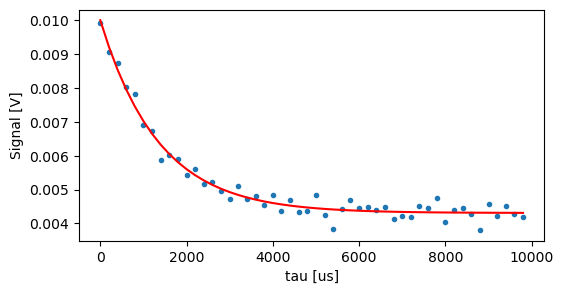

In [13]:
%matplotlib inline
tls_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp" )

## TLS drive

### TLS spectroscopy

In [357]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].tuning_curve,machine.flux_lines[flux_index].iswap.level)
TLS_freq_est = np.round(TLS_freq_est[0] * 1E6)
machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [ ]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [ ]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

In [ ]:
%matplotlib qt
TLS_freq_sweep = TLS_freq_est + np.arange(-70E6,70E6+1,1.0E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 2E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

In [ ]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
machine = Analysis.set_machine(machine)

### TLS rabi

In [ ]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 300 + 0.1, 4)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

## TLS drive debug

### 1D SWAP

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(16,300,4)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.SWAP.swap_coarse(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index, 
                n_avg = 4E3, cd_time = 20E3, simulate_flag=False, simulation_len=1000, plot_flag=True, machine = machine)

### qubit Rabi-SWAP

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.SWAP.rabi_SWAP(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,  
          pi_amp_rel = 1.0, n_avg = 4E3, cd_time = 20E3, plot_flag = True, machine = machine, simulate_flag = False, simulation_len = 10_000)

### SWAP-Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.SWAP.SWAP_rabi(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,  
          pi_amp_rel = 1.0, n_avg = 4E3, cd_time = 20E3, plot_flag = True, machine = machine, simulate_flag = False, simulation_len = 10_000)

### Rabi-SWAP-SWAP

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.SWAP.rabi_SWAP2(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,  
          pi_amp_rel = 1.0, n_avg = 4E3, cd_time = 10E3, plot_flag = True, machine = machine, simulate_flag = False, simulation_len = 10_000)